# Assignment 2
## Part 2: Scale-Space Blob Construction   
Mohammad Rashiqul Alam  
malam25@illinois.edu  

In [33]:
# Modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from scipy.ndimage import gaussian_filter, gaussian_laplace
from skimage import filters, feature, util, color

## Image Pre-Processing

### Import All ALigned Images
Import low-resolution images from ~/Gen/a2/lowres_rgb/preprocessed  
Import high-resolution images from ~/Gen/a2/hires_rgb/preprocessed

**Notebook assumes the output has been generated froma alam_rashiqul_a2_p1.pynb

In [20]:
# Import aligned images to notebook
def import_aligned_images(path, ext='jpg'):
    """
    Function to import aligned images from a specified directory, 
    only those ending with *_aligned.jpg.
    Args:
    - path: str, path to the directory containing images
    - ext: str, file extension of the images to import (default: 'jpg')
    Returns:
    - images: list of numpy arrays (each image)
    """
    images = []
    for file in os.listdir(path):
        if file.endswith(f"_aligned.{ext}"):
            img = Image.open(os.path.join(path, file))
            images.append(np.array(img))
    return images

# Plot aligned images
def plot_aligned_images(images, filenames=None, use_gray=False):
    """
    Function to plot all aligned images from the dataset.
    Args:
        images: list of numpy arrays (each image)
        filenames: list of filenames corresponding to images (optional)
        use_gray: bool, if True use grayscale colormap
    Returns:
        None
    """
    n = len(images)
    plt.figure(figsize=(2.5 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        if use_gray:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis("off")
        if filenames:
            name = filenames[i].replace('_aligned.jpg', '').replace('_aligned.jpeg', '').replace('_aligned.png', '')
            ax.set_title(name, fontsize=10)
    plt.show()

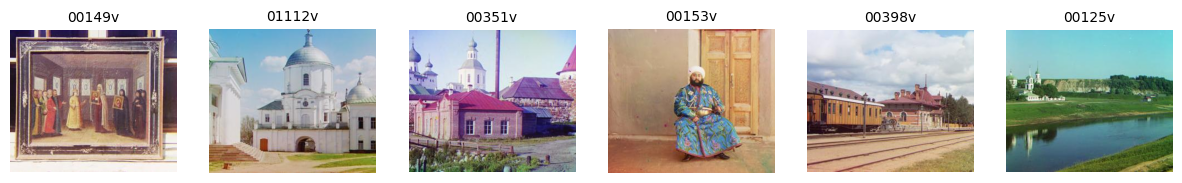

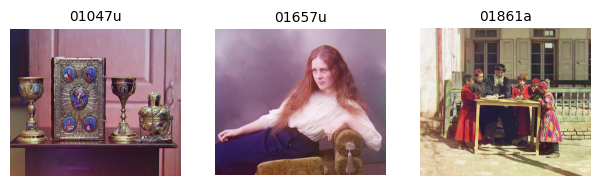

In [22]:
# Get the directory one level above the notebook location
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
lowres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "lowres_rgb", "preprocessed")
highres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "hires_rgb", "preprocessed")

# Import low-res images
low_res_images = import_aligned_images(lowres_preproc_dir, ext='jpg')
# Get filenames for low-res images
low_res_filenames = [f for f in os.listdir(lowres_preproc_dir) if f.endswith("_aligned.jpg")]
# Import high-res images
high_res_images = import_aligned_images(highres_preproc_dir, ext='jpg')
# Get filenames for high-res images
high_res_filenames = [f for f in os.listdir(highres_preproc_dir) if f.endswith("_aligned.jpg")]

# Plot images
plot_aligned_images(low_res_images, low_res_filenames, use_gray=False)
plot_aligned_images(high_res_images, high_res_filenames, use_gray=False)

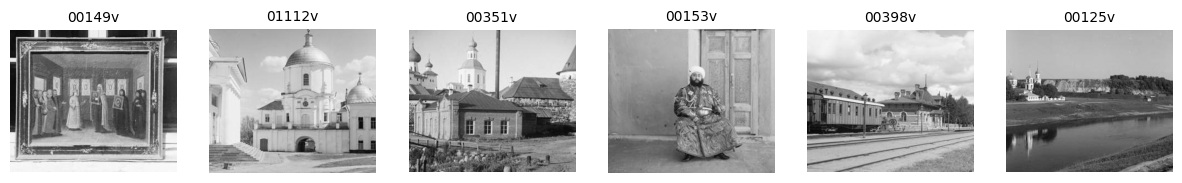

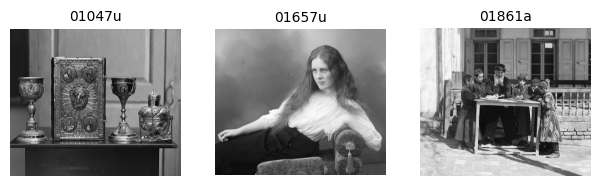

In [21]:
# Convert images to grayscale and rescale intensities to [0, 1]
low_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in low_res_images]
high_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in high_res_images]

# Plot gray-scale images
plot_aligned_images(low_res_gray, low_res_filenames, use_gray=True)
plot_aligned_images(high_res_gray, high_res_filenames, use_gray=True)

### Choice of Images for Part 2: Scale-Space Blob Construction

Selected four aligned images for this part of the assignment:
1. **00125v_aligned.jpg (Church by river)**  
   - Contains both natural features (trees, cliffs, river) and man-made structures (church buildings).  
   - Provides a mix of sharp corners and smoother regions, useful for testing corner detection and blob scale behavior.
2. **00351v_aligned.jpg (Brick house with domes)**  
   - Rich in architectural detail with windows, rooftops, and domes.  
   - Good distribution of corners and circular blob-like features at different scales.
3. **00398v_aligned.jpg (Train station with train cars)**  
   - Strong geometric patterns from train cars, station buildings, and tracks.  
   - Tests whether the method correctly preserves scale/orientation across repeating man-made structures.
4. **01047u_aligned.jpg (Chalices and book)**  
   - Objects with fine texture and small-scale blob-like details (ornamental designs, circular cups).  
   - Complements the larger-scale features in the other images with smaller, high-detail regions.

Selected image keys: dict_keys(['00125v', '00351v', '00398v', '01047u'])


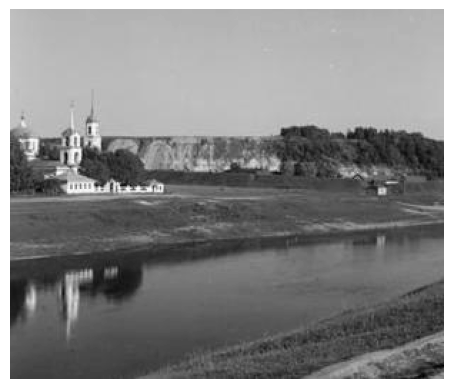

00125v


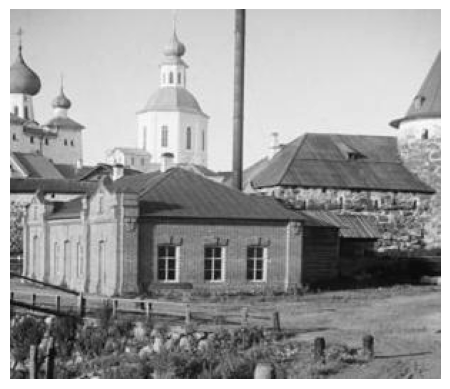

00351v


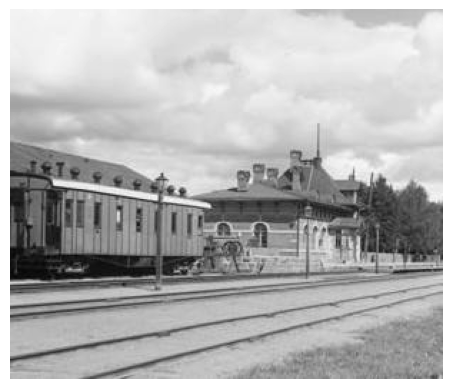

00398v


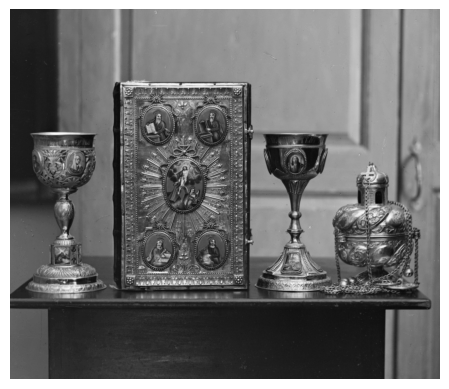

01047u


In [47]:
selected_names = [
    "00125v_aligned.jpg",
    "00351v_aligned.jpg",
    "00398v_aligned.jpg",
    "01047u_aligned.jpg"
]

# Build the dictionary
selected_images_dict = {}

# Add low-res and high-res images to the dictionary
for name in selected_names:
    key = name.replace('_aligned.jpg', '')
    # Try to find in high-res first
    if name in high_res_filenames:
        idx = high_res_filenames.index(name)
        selected_images_dict[key] = high_res_gray[idx]
    # If not found, try low-res
    elif name in low_res_filenames:
        idx = low_res_filenames.index(name)
        selected_images_dict[key] = low_res_gray[idx]
    else:
        print(f"Warning: {name} not found in either low-res or high-res images.")

# Print the keys of the selected images dictionary
print("Selected image keys:", selected_images_dict.keys())

# Plot the images
for name, image in selected_images_dict.items():
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()
    print(f"{name}")

## Build own Harris-Corner Detector
### Harris Corner Detector (based on textbook, Section 8.2.1)

Corners are a special type of **interest point**:  
- In a flat region → gradients are small in every direction.  
- Along an edge → there is a strong gradient, but only in **one** direction.  
- At a corner → there are strong gradients in **two different directions**, so the local patch cannot be slid around without changing the image content.

The Harris detector formalizes this by looking at the **second moment matrix** (also called the structure tensor) in a small neighborhood:

$$
H = \sum_{\text{window}}
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$
  
where $I_x, I_y$ are image gradients.

**Steps:**
1. **Compute image gradients**  
   Use derivative filters (e.g., Sobel or derivative of Gaussian) to obtain $I_x$ and $I_y$.

2. **Form the structure tensor**  
   Build the matrix $H$ from $I_x^2$, $I_y^2$, $I_x I_y$.  
   Smooth these terms with a Gaussian window so that the tensor reflects a local neighborhood rather than a single pixel.

3. **Analyze eigenvalues of \(H\)**  
   - If both eigenvalues are small → flat region.  
   - If one eigenvalue is large, one small → edge.  
   - If both are large → corner. :contentReference[oaicite:0]{index=0}

4. **Corner response function**  
   Instead of explicitly computing eigenvalues, Harris proposed a simple test:  
   $$
   R = \det(H) - k \cdot (\text{trace}(H))^2
   $$
   where $k$ is a constant (typically $\sim 0.04$–$0.06$).  
   Large positive values of $R$ indicate likely corners.

5. **Find local maxima**  
   Search the response map $R$ for local peaks above a threshold. 
   These become the final **corner points**.

**Key properties:**
- Harris corners are **covariant to translation and rotation** (the same points appear when the image shifts or rotates).
- They are sensitive to **contrast** (stronger response at high-contrast corners).
- They provide a compact set of distinctive, localizable points for further processing.


In [ ]:
# Default harris corner detection configurations
harris_configs = dict(
    sigma_grad=1.0,       # Gaussian smoothing scale for gradient estimation
    sigma_window=1.5,     # Gaussian window scale for structure tensor
    k=0.04,               # Harris detector free parameter (typically 0.04–0.06)
    min_distance=6,       # Minimum separation between detected corners (pixels)
    threshold_rel=0.005,  # Relative threshold for peak selection (fraction of max R)
    max_peaks=750         # Maximum number of corners to return
)

In [48]:
def compute_image_gradients(image, *, sigma_grad=1.0):
    """
    Estimate image gradients grad_x, grad_y.
    Textbook intent: derivatives at a smoothed scale (derivative-of-Gaussian).
    Implementation: light Gaussian pre-smoothing + Sobel derivatives.
    Args:
    - image: 2D numpy array (grayscale image)
    - sigma_grad: float, standard deviation for Gaussian smoothing
    Returns:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    """
    smoothed_image = filters.gaussian(image, sigma=sigma_grad, preserve_range=True, mode='reflect')
    grad_x = filters.sobel_h(smoothed_image)   # ∂I/∂x
    grad_y = filters.sobel_v(smoothed_image)   # ∂I/∂y
    return grad_x, grad_y

def compute_structure_tensor(grad_x, grad_y, *, sigma_window=1.5):
    """
    Build and smooth second-moment (structure) tensor entries in a local window.
      A = Gsigma * (grad_x^2),  B = Gsigma * (grad_y^2),  C = Gsigma * (grad_x*grad_y)
      where Gsigma is a Gaussian with sigma_window.
    Args:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    - sigma_window: float, standard deviation for Gaussian smoothing of tensor entries
    Returns:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    """
    grad_xx = grad_x * grad_x
    grad_yy = grad_y * grad_y
    grad_xy = grad_x * grad_y

    tensor_xx = filters.gaussian(grad_xx, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_yy = filters.gaussian(grad_yy, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_xy = filters.gaussian(grad_xy, sigma=sigma_window, preserve_range=True, mode='reflect')
    return tensor_xx, tensor_yy, tensor_xy

def compute_harris_response(tensor_xx, tensor_yy, tensor_xy, *, k=0.04):
    """
    Harris response:
        det(H) - k * (trace(H))^2
      with H = [[tensor_xx, tensor_xy], [tensor_xy, tensor_yy]]
    Large positive R => likely corner (both eigenvalues large).
    Args:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    - k: float, Harris detector free parameter (typically 0.04 - 0.06)
    Returns:
    - response: 2D numpy array, Harris corner response map
    """
    det_H   = tensor_xx * tensor_yy - tensor_xy * tensor_xy
    trace_H = tensor_xx + tensor_yy
    response = det_H - k * (trace_H ** 2)
    return response

def select_harris_corners(response, *, min_distance=6, threshold_rel=0.01, max_peaks=500):
    """
    Local maxima in response above relative threshold; enforce spatial separation.
    Returns Nx2 coordinates as (row=y, col=x).
    Args:
    - response: 2D numpy array, Harris corner response map
    - min_distance: int, minimum number of pixels separating peaks
    - threshold_rel: float, relative threshold for peak selection (fraction of max response)
    - max_peaks: int, maximum number of peaks to return
    Returns:
    - corner_coords: Nx2 numpy array of (row, col) coordinates of detected corners
    """
    corner_coords = feature.peak_local_max(
        response,
        min_distance=min_distance,
        threshold_rel=threshold_rel,
        num_peaks=max_peaks
    )
    return corner_coords

In [49]:
# Harris corner detection function
def harris_corner_detector(
    image, 
    sigma_grad=1.0, 
    sigma_window=1.5, 
    k=0.04, 
    min_distance=6, 
    threshold_rel=0.01, 
    max_peaks=500
):
    """
    Function to perform Harris corner detection on a grayscale image.
    Args:
        image: 2D numpy array, input grayscale image
        sigma_grad: float, Gaussian smoothing scale for gradient estimation
        sigma_window: float, Gaussian window scale for structure tensor
        k: float, Harris detector free parameter (typically 0.04–0.06)
        min_distance: int, minimum separation between detected corners (pixels)
        threshold_rel: float, relative threshold for peak selection (fraction of max R)
        max_peaks: int, maximum number of corners to return
    Returns:
        harris_response: 2D numpy array, Harris response image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
    """
    # Step 1: Compute image gradients
    grad_x, grad_y = compute_image_gradients(image, sigma_grad=sigma_grad)
    # Step 2: Compute structure tensor components
    tensor_xx, tensor_yy, tensor_xy = compute_structure_tensor(grad_x, grad_y, sigma_window=sigma_window)
    # Step 3: Compute Harris response
    harris_response = compute_harris_response(tensor_xx, tensor_yy, tensor_xy, k=k)
    # Step 4: Select corners from the response
    corner_coords = select_harris_corners(
        harris_response, 
        min_distance=min_distance, 
        threshold_rel=threshold_rel, 
        max_peaks=max_peaks
    )
    # Return response and coordinates
    return harris_response, corner_coords

In [50]:
def plot_corner_overlay(image, corner_coords, title="Harris corners"):
    """
    Overlay detected corners on the image.
    Args:
        image: 2D numpy array, grayscale image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
        title: str, plot title
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    if len(corner_coords) > 0:
        ax.plot(corner_coords[:, 1], corner_coords[:, 0], 'r.', markersize=3)
    ax.set_title(f"{title} — {len(corner_coords)} corners")
    ax.axis('off')
    plt.show()

In [51]:
# Entry function for Harris corner detection
def run_harris_on_selected_images(selected_images_dict, show=True):
    """
    Function to run harris corner detection on selected images.
    Args:
        selected_images_dict: dictionary containing selected images
        show: if True display the results
    Returns:
        results: dictionary with Harris corner detection results
    """
    results = {}
    for name, image in selected_images_dict.items():
        harris_response, corner_coords = harris_corner_detector(image, **harris_configs)
        if show:
            plot_corner_overlay(image, corner_coords, title=f"{name}")
        results[name] = {'response': harris_response, 'coords': corner_coords}
    return results

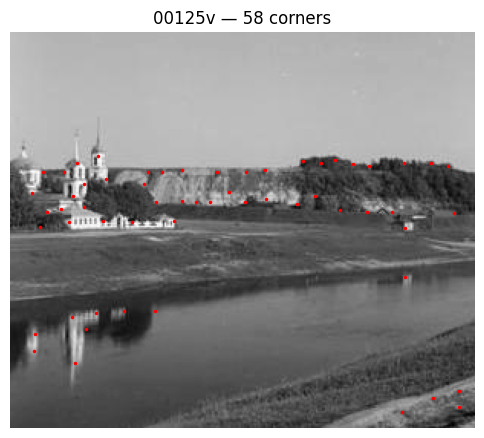

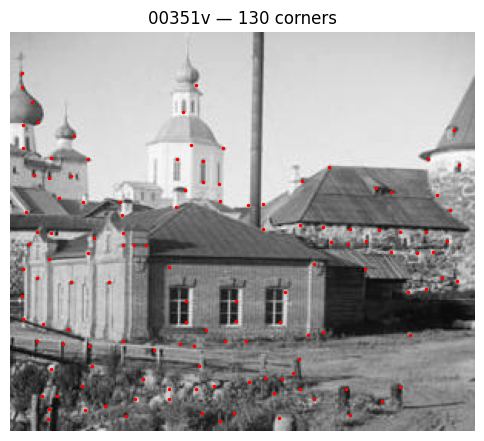

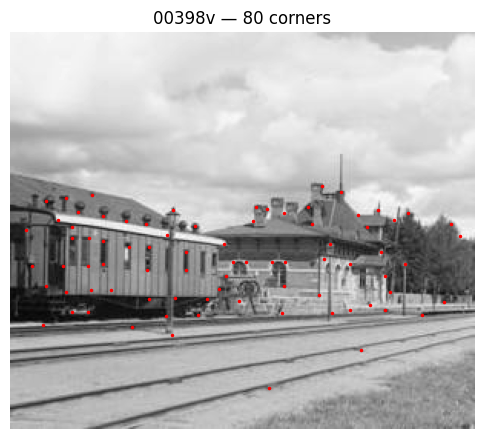

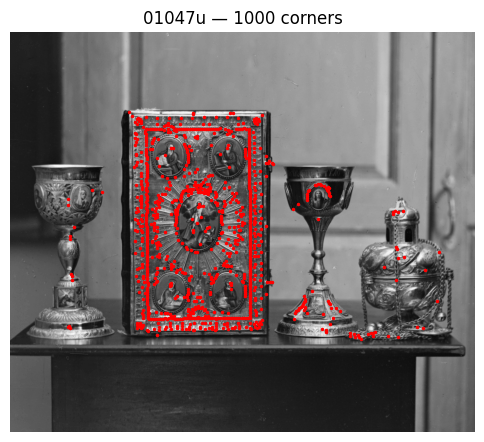

00125v corners: 58
00351v corners: 130
00398v corners: 80
01047u corners: 1000


In [56]:
# Run Harris corner detection on selected images
harris_results = run_harris_on_selected_images(selected_images_dict, show=True)

# Print number of corners detected in each image
for k, v in harris_results.items():
    print(k, "corners:", len(v['coords']))